In [49]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt



In [14]:
index = []
values= []
with open("rcv1rcv2aminigoutte/EN/Index_EN-EN") as rcv1:
    for line in rcv1.readlines():
        line = line.strip()
        index.append(line.split(' ')[0])
        values.append(line.split(' ')[1:])
        

matrix = np.zeros((len(index),21531))

for i, row in enumerate(values):
    for val in row:
        tup = val.split(':')
        col = int(tup[0])-1
        matrix[i][col] = float(tup[1])

features = np.array(matrix)

In [88]:
def standardize(x):
    centered_data = np.subtract(x, np.nanmean(x, axis=0))
    std_data = centered_data / np.nanstd(centered_data, axis=0)
    std_data = np.nan_to_num(std_data)
    return std_data

In [89]:
features = standardize(features)

In [100]:
def hinge_loss(y, X, w):
    loss = np.zeros(y.shape)
    f = X@w
    ## Penalize but indicative for the prints
    for i in range(len(y)):
        if y[i] == 1 and f[i] < 1:
            loss[i] = (1-y[i]*f[i])*9
        else:
            loss[i] = 1-y[i]*f[i]
    #print(np.clip(loss,0, np.inf))
    return np.clip(loss,0, np.inf)

In [102]:
def SGD(y,X,w, lambda_, n, num_examples):
    def is_support(y_n, x_n, w):
        return y_n * x_n @w < 1
    x_n, y_n = X[n], y[n]
    ## Penalize the gradient
    if y_n == 1 and x_n@w <1:
        grad = - 8*y_n * x_n.T if is_support(y_n, x_n, w) else np.zeros_like(x_n.T)
    else:
        grad = - y_n * x_n.T if is_support(y_n, x_n, w) else np.zeros_like(x_n.T)
    grad = num_examples * np.squeeze(grad) + lambda_ * w
    return grad
    

In [29]:
def calculate_primal(y, X, w, lambda_):
    v = hinge_loss(y, X, w)
    return np.sum(v) + lambda_ / 2 * np.sum(w**2)

In [104]:
def sgd_for_svm(y,X):
    max_iter = 500000
    gamma = 0.3
    lambda_ = 0.01
    num_examples, num_features = features.shape
    w = np.zeros(num_features)
    for it in range(max_iter):
        n = random.randint(0, num_examples-1)
        grad = SGD(y, X, w, lambda_, n, num_examples)
        w-= gamma*grad
        
        if it % 10000 == 0:
            cost = calculate_primal(y, X, w, lambda_)
            print("iteration={i}, cost={c}".format(i=it, c=cost))
    print("training accuracy = {l}".format(l=calculate_accuracy(y, X, w)))


In [72]:
def create_labels(index, category):
    def convert_to_bin(cat):
        return 1 if cat == category else -1
    labels = map(convert_to_bin, index)
    return np.array(list(labels))

In [41]:
def accuracy(y1, y2):
    return np.mean(y1 == y2)

def prediction(X, w):
    return (X @ w > 0) * 2 - 1
def calculate_accuracy(y, X, w):
    """compute the training accuracy on the training set (can be called for test set as well).
    X: the full dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_features)
    """
    predicted_y = prediction(X, w)
    return accuracy(predicted_y, y)

In [105]:
sgd_for_svm(create_labels(index, "ECAT"), features)

iteration=0, cost=10571299882.448761
iteration=10000, cost=1752540602381.3203
iteration=20000, cost=852422574472.197
iteration=30000, cost=1060010910779.144
iteration=40000, cost=797671423073.464
iteration=50000, cost=997120159202.276
iteration=60000, cost=706664855971.6936
iteration=70000, cost=618987768120.8668
iteration=80000, cost=1359550614415.2273
iteration=90000, cost=1623364232411.3813
iteration=100000, cost=1455578079443.3987
iteration=110000, cost=1128302078851.5474
iteration=120000, cost=1308672337701.6719
iteration=130000, cost=983776515718.244
iteration=140000, cost=1491900643247.9048
iteration=150000, cost=1278623565007.5015
iteration=160000, cost=879577748201.2035
iteration=170000, cost=1380504137181.4575
iteration=180000, cost=1393569653995.48
iteration=190000, cost=777805729241.6956
iteration=200000, cost=1405240023366.2993
iteration=210000, cost=1328670182925.471
iteration=220000, cost=1048743047321.5085
iteration=230000, cost=1695170163497.0564
iteration=240000, cost

In [106]:
def calculate_coordinate_update(y, X, lambda_, alpha, w, n):
    """compute a coordinate update (closed form) for coordinate n.
    X: the dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_examples)
    n: the coordinate to be updated
    """        
    # calculate the update of coordinate at index=n.
    x_n, y_n = X[n], y[n]
    old_alpha_n = np.copy(alpha[n])
    
    ## Penalize coordinate update
    if y_n == 1 and x_n.dot(w) < 1:
        g = (y_n * x_n.dot(w) - 1)*8
    else:
        g = (y_n * x_n.dot(w) - 1)
    

    if old_alpha_n == 0:
        g = min(g, 0)
    elif old_alpha_n == 1.0:
        g = max(g, 0)
    else:
        g = g
    if g != 0:
        alpha[n] = min(
            max(old_alpha_n - lambda_ * g / (x_n.T.dot(x_n)), 0.0),
            1.0)
    
        # compute the corresponding update on the primal vector w
        w += 1.0 / lambda_ * (alpha[n] - old_alpha_n) * y_n * x_n
    return w, alpha

In [97]:
def calculate_dual_objective(y, X, w, alpha, lambda_):
    """calculate the objective for the dual problem."""
    return np.sum(alpha)  - lambda_ / 2.0 * np.sum(w ** 2) # w = 1/lambda * X * Y * alpha

In [108]:
def coordinate_descent_for_svm_demo(y, X):
    max_iter = 500000
    lambda_ = 0.01

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    
    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0,num_examples-1)
        
        w, alpha = calculate_coordinate_update(y, X, lambda_, alpha, w, n)
            
        if it % 10000 == 0:
            # primal objective
            primal_value = calculate_primal(y, X, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, X, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value
            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
    print("training accuracy = {l}".format(l=calculate_accuracy(y, X, w)))

coordinate_descent_for_svm_demo(create_labels(index, "ECAT"), features)

iteration=0, primal:35203.40957, dual:0.00000, gap:35203.40957
iteration=10000, primal:15074.65233, dual:-0.00060, gap:15074.65294
iteration=20000, primal:13720.24460, dual:0.00170, gap:13720.24290
iteration=30000, primal:12201.08163, dual:0.00429, gap:12201.07734
iteration=40000, primal:11560.19332, dual:0.00641, gap:11560.18691
iteration=50000, primal:10520.88281, dual:0.00812, gap:10520.87469
iteration=60000, primal:9482.74840, dual:0.00982, gap:9482.73858
iteration=70000, primal:8741.84638, dual:0.01176, gap:8741.83462
iteration=80000, primal:7839.85733, dual:0.01296, gap:7839.84437
iteration=90000, primal:7514.18890, dual:0.01430, gap:7514.17460
iteration=100000, primal:6915.74568, dual:0.01533, gap:6915.73035
iteration=110000, primal:6446.46714, dual:0.01634, gap:6446.45080
iteration=120000, primal:6146.14696, dual:0.01720, gap:6146.12976
iteration=130000, primal:5659.81303, dual:0.01793, gap:5659.79510
iteration=140000, primal:5295.10450, dual:0.01853, gap:5295.08597
iteration=1

In [91]:
343136861493/features.shape[0]

18292827.67315279

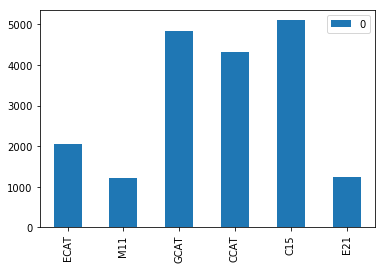

In [62]:
import pandas
from collections import Counter
letter_counts = Counter(index)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.show()

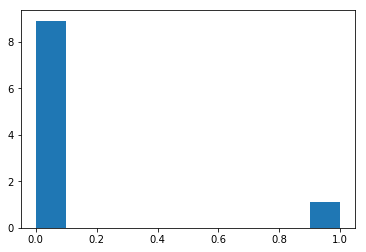

In [65]:
plt.hist(create_labels(index, "ECAT"), normed= True)
plt.show()